# Phase I - Neural Networks between Focus Species & Other Species

## Import Modules

In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.utils.data as Data
from sklearn.preprocessing import StandardScaler
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set seed
torch.cuda.manual_seed(1)
# Switch to GPU for Training
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
# Clear GPU caches
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary())

## Hyper-parameters Setup

In [3]:
batch_size = 50

## Load datset & Feature Engineering

In [4]:
# set random seed
np.random.seed(seed=2)
# load dataset
trainset = pd.read_csv("phase_1_trainset.csv")
testset = pd.read_csv("phase_1_testset.csv")

In [5]:
# get species list
species_list = list(set([i for i in trainset["species_cat_01"]]))
label_dict = {}
for i, spe in enumerate(species_list):
    label_dict[spe] = i
label_dict

{'Focus Species': 0, 'Other Species': 1}

In [6]:
# generate label column
trainset["label"] = trainset["species_cat_01"].apply(lambda x: label_dict[x])
testset["label"] = testset["species_cat_01"].apply(lambda x: label_dict[x])
trainset = trainset.sample(frac=1)
testset = testset.sample(frac=1)

In [7]:
trainset = np.array(trainset)
testset = np.array(testset)
print("Trainset Shape: ", trainset.shape)
print("Testset Shape: ", testset.shape)

Trainset Shape:  (48213, 3)
Testset Shape:  (5458, 3)


### Train/Test Split and Data Preparation

In [8]:
train_x = trainset[:,0].reshape(-1,1)
train_y = trainset[:,-1]
test_x = testset[:,0].reshape(-1,1)
test_y = testset[:,-1]

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(48213, 1) (48213,)
(5458, 1) (5458,)


## Training Piepeline

### Normalization

In [9]:
scaler_minmax = StandardScaler()
train_x = scaler_minmax.fit_transform(train_x)
test_x = scaler_minmax.fit_transform(test_x)

### Conver to Tensors

In [10]:
# float32 conversion
train_x = train_x.astype(np.float32)
train_y = train_y.astype(np.int32)
test_x = test_x.astype(np.float32)
test_y = test_y.astype(np.int32)

### Dataloaders

In [11]:
class Species_Datasets(torch.utils.data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.FloatTensor(data_inputs)
        self.label = torch.FloatTensor(data_targets)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [12]:
trainset = Species_Datasets(train_x, train_y)
testset = Species_Datasets(test_x, test_y)
TrainDataLoader = Data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=False)
TestDataLoader = Data.DataLoader(testset, batch_size=batch_size, shuffle=True, drop_last=False)

In [13]:
for batch_idx, (data, targets) in enumerate(TrainDataLoader):
    print(data.shape,targets.shape)
    print(data[0].shape)
    break

torch.Size([50, 1]) torch.Size([50])
torch.Size([1])


### Deep Neural Networks

In [14]:
class DNN_Model(nn.Module):
    # Networks
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(train_x.shape[1],16)
        self.hidden2 = nn.Linear(16,32)
        self.hidden3 = nn.Linear(32,16)
        self.out = nn.Linear(16,len(label_dict))
        self.activation = nn.Sigmoid()
        self.dropout = nn.Dropout(0.1)

    # Feed Forward
    def forward(self, x):
        x = self.hidden1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.hidden3(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [15]:
net = DNN_Model().to(device) # Create a net instance
net

DNN_Model(
  (hidden1): Linear(in_features=1, out_features=16, bias=True)
  (hidden2): Linear(in_features=16, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=2, bias=True)
  (activation): Sigmoid()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Training Model

In [16]:
# Preparing list to record
summary_train_loss = []
summary_train_accuracy = []
summary_val_loss = []
summary_val_accuracy = []

In [17]:
# Function: Train model
def model_fit_train(class_weight, learning_rate, epochs, summary_train_loss, summary_train_accuracy, summary_val_loss, summary_val_accuracy):
    if class_weight != None:
        loss_func = torch.nn.CrossEntropyLoss(weight = class_weight)
    else:
        loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr = learning_rate)

    for epoch in tqdm(range(epochs), desc='Training'):
        train_accuracy = []
        train_loss = []
        val_accuracy = []
        val_loss = []
        
        # ===== Train Mode =====
        net.train()
        for batch_idx, (x_input, y_true) in enumerate(TrainDataLoader):
            # Put data to device
            x_input = x_input.to(device)
            y_true = y_true.to(device)
            # Fit model
            y_pred = net(x_input)
            # Compute loss
            loss = loss_func(y_pred,y_true.long())
            # Reset gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Get prediction
            prediction = torch.max(y_pred,1)[1]
            prediction = prediction.data.cpu().numpy().squeeze()

            label = y_true.data.cpu().numpy()
            # Compute accuracy
            accuracy = float((prediction == label).astype(int).sum())/float(prediction.size)
            # Append loss and accuracy
            train_loss.append(loss.item())
            train_accuracy.append(accuracy)
        # append the average result from one epoch
        summary_train_loss.append(np.mean(np.array(train_loss)))
        summary_train_accuracy.append(np.mean(np.array(train_accuracy)))
        

        # ===== Validation Mode =====
        net.eval()
        val_prediction_list = [] # record the validation prediction result for confusion matrix computation
        val_true_list = []
        for batch_id, (val_data,val_label) in enumerate(TestDataLoader):
            # Put data to device
            x_val = val_data.to(device)
            y_val = val_label.to(device)
            # get prediction
            val_pred = net(x_val)
            # Compute loss
            val_losses = loss_func(val_pred,y_val.long())
            # prediction
            val_pred = torch.max(val_pred,1)[1]
            val_pred = val_pred.data.cpu().numpy().squeeze()
            # append val_prediction_list
            val_prediction_list += val_pred.tolist()
            
            val_label = y_val.data.cpu().numpy()
            val_true_list += val_label.tolist() 
            
            # Compute accuracy
            val_acc = float((val_pred == val_label).astype(int).sum())/float(val_pred.size)
            # Append loss and accuracy
            val_loss.append(val_losses.item())
            val_accuracy.append(val_acc)
        # append the average result from one epoch
        summary_val_loss.append(np.mean(np.array(val_loss)))
        summary_val_accuracy.append(np.mean(np.array(val_accuracy)))
        
        # print result
        if str(epoch).endswith("0"):
            print("Epoch: ",epoch+1,"/",epochs,"Training Loss: ", summary_train_loss[-1], "| Training Accuracy: ", summary_train_accuracy[-1], "| Validation Loss: ", summary_val_loss[-1], "| Validation Accuracy: ", summary_val_accuracy[-1])
    return val_true_list, val_prediction_list

#### Phase I - Training

In [18]:
epochs = 120
learning_rate = 0.00003
class_weights = torch.tensor([1.0,1.0])

In [19]:
val_true_list, val_pred_list = model_fit_train(class_weights, learning_rate, epochs, summary_train_loss, summary_train_accuracy, summary_val_loss, summary_val_accuracy)

Training:   1%|          | 1/120 [00:01<02:36,  1.31s/it]

Epoch:  1 / 120 Training Loss:  0.6901612976054453 | Training Accuracy:  0.540146671980869 | Validation Loss:  0.6963003001429818 | Validation Accuracy:  0.5


Training:   9%|▉         | 11/120 [00:14<02:22,  1.31s/it]

Epoch:  11 / 120 Training Loss:  0.6784548967613457 | Training Accuracy:  0.5423818254284576 | Validation Loss:  0.6826942254196514 | Validation Accuracy:  0.5026818181818182


Training:  18%|█▊        | 21/120 [00:28<02:17,  1.38s/it]

Epoch:  21 / 120 Training Loss:  0.6626116722358941 | Training Accuracy:  0.6147198086887207 | Validation Loss:  0.6660850335251202 | Validation Accuracy:  0.613318181818182


Training:  26%|██▌       | 31/120 [00:41<02:00,  1.35s/it]

Epoch:  31 / 120 Training Loss:  0.6605155757671811 | Training Accuracy:  0.6201578318055001 | Validation Loss:  0.6645295002243735 | Validation Accuracy:  0.6272727272727273


Training:  34%|███▍      | 41/120 [00:55<01:47,  1.36s/it]

Epoch:  41 / 120 Training Loss:  0.6589047297294893 | Training Accuracy:  0.6228202471104026 | Validation Loss:  0.6619063583287326 | Validation Accuracy:  0.6339090909090909


Training:  42%|████▎     | 51/120 [01:08<01:34,  1.37s/it]

Epoch:  51 / 120 Training Loss:  0.6584809923419063 | Training Accuracy:  0.6248481466719809 | Validation Loss:  0.6621114405718717 | Validation Accuracy:  0.636909090909091


Training:  51%|█████     | 61/120 [01:23<01:22,  1.41s/it]

Epoch:  61 / 120 Training Loss:  0.6573987191205197 | Training Accuracy:  0.6264551614188919 | Validation Loss:  0.660183211890134 | Validation Accuracy:  0.6369545454545454


Training:  59%|█████▉    | 71/120 [01:36<01:07,  1.38s/it]

Epoch:  71 / 120 Training Loss:  0.6565605039423611 | Training Accuracy:  0.628910322837784 | Validation Loss:  0.6597731389782645 | Validation Accuracy:  0.6388181818181817


Training:  68%|██████▊   | 81/120 [01:50<00:52,  1.35s/it]

Epoch:  81 / 120 Training Loss:  0.6565958084837761 | Training Accuracy:  0.6287142287764049 | Validation Loss:  0.6591306242075834 | Validation Accuracy:  0.6399090909090909


Training:  76%|███████▌  | 91/120 [02:04<00:40,  1.40s/it]

Epoch:  91 / 120 Training Loss:  0.6560027649365558 | Training Accuracy:  0.6288035073734556 | Validation Loss:  0.6597572901032188 | Validation Accuracy:  0.6384090909090908


Training:  84%|████████▍ | 101/120 [02:18<00:26,  1.41s/it]

Epoch:  101 / 120 Training Loss:  0.655143090233284 | Training Accuracy:  0.6298541251494618 | Validation Loss:  0.6588725989515131 | Validation Accuracy:  0.6389545454545454


Training:  92%|█████████▎| 111/120 [02:32<00:12,  1.37s/it]

Epoch:  111 / 120 Training Loss:  0.6548308473794572 | Training Accuracy:  0.6295846950976485 | Validation Loss:  0.6581651649691842 | Validation Accuracy:  0.6391363636363636


Training: 100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


#### Evaluation - Confusion Matrix

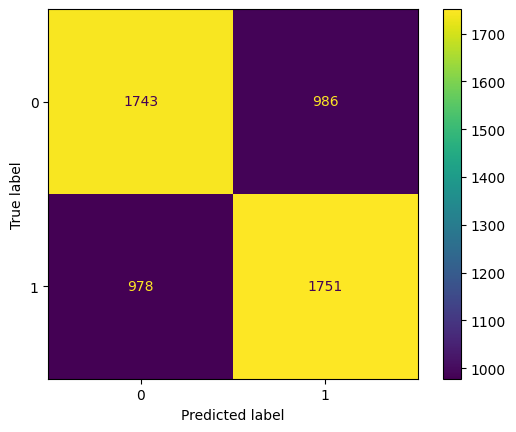

In [20]:
cm = confusion_matrix(val_true_list, val_pred_list)
cm_display = ConfusionMatrixDisplay(cm).plot()

#### Evaluation - Scores

In [21]:
print("Accuracy Score: ", accuracy_score(val_true_list, val_pred_list))
print("Precision Score: ", precision_score(val_true_list, val_pred_list, average='macro'))
print("Recall Score: ", recall_score(val_true_list, val_pred_list, average='macro'))
print("F1 Score: ", f1_score(val_true_list, val_pred_list, average='macro'))

Accuracy Score:  0.6401612312202272
Precision Score:  0.6401624357139433
Recall Score:  0.6401612312202272
F1 Score:  0.6401604581449293


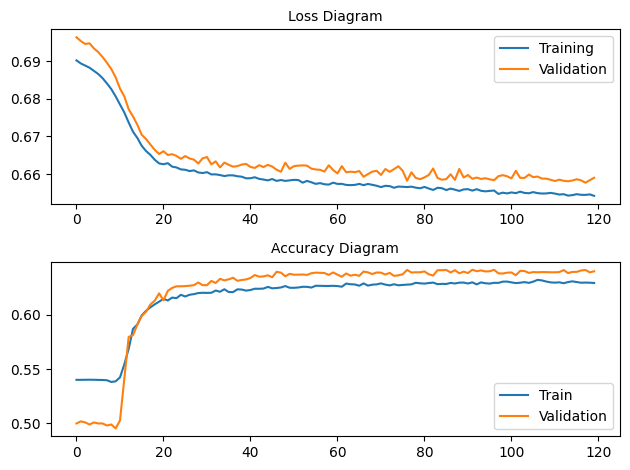

In [22]:
plt.subplot(2, 1, 1)
plt.plot(np.array(summary_train_loss),label="Training")
plt.plot(np.array(summary_val_loss),label="Validation")
plt.title("Loss Diagram", fontsize = 10)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.array(summary_train_accuracy),label="Train")
plt.plot(np.array(summary_val_accuracy),label="Validation")
plt.title("Accuracy Diagram", fontsize = 10)
plt.legend()
plt.tight_layout()

#### Save model to local disk

In [23]:
# Save Model Path
path = "Phase I - Species Distribution Model.pth"
torch.save(net.state_dict(),path)
print("Model saved to local disk.")

Model saved to local disk.


In [24]:
evaluation = pd.DataFrame(columns = ["train loss","train accuracy","validation loss","validation accuracy"])
evaluation["train loss"] =summary_train_loss
evaluation["train accuracy"] =summary_train_accuracy
evaluation["validation loss"] =summary_val_loss
evaluation["validation accuracy"] = summary_val_accuracy
evaluation.to_csv("Phase I - model_evaluation.csv",index=False,mode="a",header=None)
print("Evaluation Metrics saved to local disk.")

Evaluation Metrics saved to local disk.
